# IDPI Play Ground
This is the play ground for IDPI image privacy protection.    
The code is write in Colab, it will be better to run this code in Colab. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
cd drive/MyDrive/GANsLatentCode/

/content/drive/MyDrive/GANsLatentCode


# Section 1 Initialize

Download the ninja v1.8.2 package.(Skip if downloaded)

In [ ]:
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip

Install and update new ninjia

In [2]:
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

Archive:  ninja-linux.zip
  inflating: /usr/local/bin/ninja    
update-alternatives: using /usr/local/bin/ninja to provide /usr/bin/ninja (ninja) in auto mode


In [4]:
import os
main_folder_path = '/content/drive/MyDrive/GANsLatentCode' #
os.chdir(main_folder_path)
CODE_DIR = 'pixel2style2pixel/'

In [6]:
cd pixel2style2pixel/

/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel


In [7]:
from argparse import Namespace
import time
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(".")
sys.path.append("..")

# from scripts import id_loss_cal
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

# data path is a temporary path to save image generated in loop
data_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_generated'
# gt path is a temporary path to save original image generated from latent code
gt_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_groundtruth'
# image path is the path of original image
image_path = CODE_DIR+'notebooks/images/00000/00003.png'
# target image path is the path when using targeted mode
targeted_image_path = CODE_DIR+'notebooks/images/00000/00001.png'
# path image gen and path image gt is the path of temp image
path_image_gen = data_path+'/temp_image.png'
path_image_GT = gt_path+'/temp_image.png'
# latent avg path is the path of average latent, use it for untargeted mode
latent_avg_path = CODE_DIR+'notebooks/results/average_latent.npy'
# latent_AVG = np.load(latent_avg_path)


experiment_type = 'ffhq_encode'

EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
pprint.pprint(opts)
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': 'pretrained_models/psp_ffhq_encode.pt',
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


# Section 2 Functions

## 2.1 Functions for generate image

In [8]:
import dlib
from scripts.align_all_parallel import align_face

def run_alignment(image_path, default_lm=[]):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image, lm = align_face(filepath=image_path, predictor=predictor, default_lm=default_lm) 
    # print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image, lm

def run_on_batch(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=False, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def run_on_gen(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=True, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def hy_latent(latent_np):
#     hy_latent = torch.from_numpy(np.array([latent_np]))
    hy_latent = torch.from_numpy(latent_np)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

def Image2Image_initial(image,targeted_image_path,path_img_gen,path_img_GT,latent_average,input_img_path=True,targeted=True):
    if input_img_path:
        image_path = image
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        print('load image from:',image)
    else:
        original_image = image.convert("RGB")
        print('load image from Input image')
        
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    transformed_image = img_transforms(original_image)

    with torch.no_grad():
        tic = time.time()
        result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        toc = time.time()
        print('Generate original latent code took {:.4f} seconds.'.format(toc - tic))
        
    result_image.size()
    result_image = result_image[0]
    output_image = tensor2im(result_image)
    res_image = Image.fromarray(np.array(output_image.resize((256, 256))))
    plt.imshow(res_image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    res_image.save(path_img_GT)
    
    if targeted:
        print('select target image from:',targeted_image_path)
        generated_image = Image.open(targeted_image_path)
        generated_image = generated_image.convert("RGB")
        
        transformed_image_g = img_transforms(generated_image)
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_batch(transformed_image_g.unsqueeze(0), net)
            toc = time.time()
            print('Generate targeted image latent code took {:.4f} seconds.'.format(toc - tic))
            
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Targeted Image')
        plt.show()
        res_image_g.save(path_img_gen)
        
    else:
        print('untargeted mode use average latent code')
        
        latent_avg = latent_average
        latent2cuda = latent_avg
        latent_tensor = hy_latent(latent2cuda)
#         latent_tensor.shape
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_gen(latent_tensor.unsqueeze(0), net)
            toc = time.time()
            print('Generate untargeted image from average latent code took {:.4f} seconds.'.format(toc - tic))
        
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Untargeted Image')
        plt.show()
        res_image_g.save(path_img_gen)

    return codes,codes_g,path_img_GT,path_img_gen

def generate_latent_from_path(img_path,net):
    img_list = os.listdir(img_path)
    img_list.sort()
    len_img = len(img_list)
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    
    latent_list = np.zeros([int(len_img),18,512])
    assert len_img!=0, "No image in folder"
    print(len_img,'images in folder!')
    
    for i in range(len_img):
        image_path = img_path+'/'+img_list[i]
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        original_image.resize((256, 256))
        predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        input_image,_ = align_face(filepath=image_path, predictor=predictor) 
        # print(type(input_image))
        if type(input_image)==int:
            print('no latent image:',i)
        else:
            transformed_image = img_transforms(input_image)
            with torch.no_grad():
                result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        
        latent_np = latent.cpu().detach().numpy()
        latent_list[i] = latent_np[0]
        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
    print('latent generation complete!')    
    return latent_list

def move_latent_and_save(latent_vector, direction_file, coeffs):
    direction = np.load('latent_directions/' + direction_file)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        latent_tensor = hy_latent(new_latent_vector)
        with torch.no_grad():
            result_image_g, latent_g,codes_g = run_on_gen(latent_tensor, net)
        result_image_temp = result_image_g[0]
        output_image_temp = tensor2im(result_image_temp)
        res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
        # res_image_temp.thumbnail(size, Image.ANTIALIAS)
        # res_image_temp.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return res_image_temp

def generate_id_latent(latent):
  latent_I = latent.copy()
  # seed = int(abs(latent_I[0,0]*1000))
  np.random.seed(2337)
  latent_rand = np.random.randint(0,61,size=(18,512))

  latent_id = latent_I.copy()
  latent_id[0:7] = latent_rand[0:7]*latent_id[0:7]/60
  latent_ad = latent_id
  return latent_ad

import cv2
def generate_mask(lm):
    im1 = np.zeros((256,256), dtype="uint8")
    cor_xy1 = np.vstack((lm[0:17],np.flipud(lm[17:27])))
    # print(np.shape(cor_xy1))
    cv2.polylines(im1, np.int32([cor_xy1]), 1, [255,255,255])
    cv2.fillPoly(im1, np.int32([cor_xy1]), 1)
    mask_array1 = im1
    # plt.imshow(mask_array1)
    # plt.axis('off')
    # plt.show()
    return mask_array1

def facenet_embedding(input_im):
    import torch
    import torchvision.transforms as trans

    sys.path.append(".")
    sys.path.append("..")

    from models.mtcnn.mtcnn import MTCNN
    from models.encoders.model_irse import IR_101
    from configs.paths_config import model_paths
    CIRCULAR_FACE_PATH = model_paths['circular_face']

    facenet = IR_101(input_size=112)
    facenet.load_state_dict(torch.load(CIRCULAR_FACE_PATH))
    facenet.cuda()
    facenet.eval()
    mtcnn = MTCNN()
    id_transform = trans.Compose([
      trans.ToTensor(),
      trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    input_img, _ = mtcnn.align(input_im)
    input_id = facenet(id_transform(input_img).unsqueeze(0).cuda())[0]
    return input_id

import cv2
def generate_mask(lm):
    im1 = np.zeros((256,256), dtype="uint8")
    cor_xy1 = np.vstack((lm[0:17],np.flipud(lm[17:27])))
    # print(np.shape(cor_xy1))
    cv2.polylines(im1, np.int32([cor_xy1]), 1, [255,255,255])
    cv2.fillPoly(im1, np.int32([cor_xy1]), 1)
    mask_array1 = im1
    # plt.imshow(mask_array1)
    # plt.axis('off')
    # plt.show()
    return mask_array1

## 2.2 Functions to evaluate

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import sys
import random
import copy
from skimage.metrics import structural_similarity as ssim
from numpy import linalg as LA

sys.path.append("/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel")
from scripts import id_loss_cal
# from pytorch_fid import fid_score
sys.path.append("/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/pytorchfid/src")

from pytorch_fid import fid_score
from facenetpytorch import MTCNN, InceptionResnetV1

resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=256, margin=80)
# sys.path.append("/home/csp-uts/Hanyu/facenet/src")
# from face_ID_loss import load_and_align_data,clac_loss
# import facenet

img_transforms = EXPERIMENT_ARGS['transform']
def hy_blur(img,blur_size):
    blur = cv2.blur(img,(blur_size,blur_size))
    return blur

def hy_mosaic(image,size):
    img = copy.copy(image)
    x,y,_ = img.shape
    for i in range(0,x-size,size):
        for j in range(0,y-size,size):
            img[i:i+size,j:j+size] = img[i+(size//2)][j+(size//2)]
    return img

            
def hy_L2(img,img_noise):
    a = img-img_noise
    b = a.flatten()
    L2_score = LA.norm(b)
    return L2_score

def hy_ALDp(img,img_noise):
    a = copy.copy(img)
    b = copy.copy(img_noise)
    c = a-b
    a1 = LA.norm(c[:,:,0], ord=np.inf)/LA.norm(a[:,:,0], ord=np.inf)
    a2 = LA.norm(c[:,:,1], ord=np.inf)/LA.norm(a[:,:,1], ord=np.inf)
    a3 = LA.norm(c[:,:,2], ord=np.inf)/LA.norm(a[:,:,2], ord=np.inf)
    ALDp_score = np.mean([a1,a2,a3])
    return ALDp_score
    
def hy_SSIM(img,img_noise):
    ssim_noise = ssim(img, img_noise,multichannel=True)
    return ssim_noise

def hy_FID(gt_path,re_path):
    # gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt'
    # re_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
    paths = [gt_path,re_path]
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    fidscore = fid_score.calculate_fid_given_paths(paths=paths,batch_size=1,device=device,dims=2048)
    return fidscore

def hy_MSapi(faceId1,res_image_g):
    faceId2 = find_faceID(res_image_g)
    result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
    if not 'isIdentical' in result.keys():
        return 0
    else:
        return result['confidence']


def hy_arcface(gt_image,res_image_g,gt_path):
    score_temp = id_loss_cal.extract_on_images(gt_image,res_image_g,gt_path)
    if score_temp == None:
        return 0
    else:
        ID_score = score_temp[os.path.basename(gt_path)]
        return ID_score


def hy_facenet(gt_path,data_path):
    img1 = Image.open(gt_path)
    img2 = Image.open(data_path)
    transformed_image1 = img_transforms(img1)
    transformed_image2 = img_transforms(img2)
    embedding1 = resnet(transformed_image1.unsqueeze(0))
    embedding2 = resnet(transformed_image2.unsqueeze(0))
    e1 = embedding1.detach().numpy()[0]
    e2 = embedding2.detach().numpy()[0]
    E = (e1-e2)
    facenet_score = LA.norm(E)
    return facenet_score



## 2.3 (Optional) functions to use MSapi if applicable

In [10]:
import requests
import json
import http.client, urllib.request, urllib.parse, urllib.error, base64

def find_faceID(image_path):
    # set to your own subscription key value
    subscription_key = '10a6c23899014adeae1999a75e388276'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'

    assert subscription_key
    
    face_api_url = 'https://facedetectedfree.cognitiveservices.azure.com/face/v1.0/detect'

    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/3/37/Dagestani_man_and_woman.jpg'
    # Set image_path to the local path of an image that you want to analyze.
    image_path = image_path

    # Read the image into a byte array
    image_data = open(image_path, "rb").read()

    headers = {
      'Content-Type': 'application/octet-stream',
      'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
      'returnFaceId': 'true',
      'returnFaceLandmarks': 'false',
      # 'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    response = requests.post(face_api_url, params=params,
                          headers=headers, data=image_data)
    if type(response.json()) is list:
        if len(response.json()) != 0:
            faceId = response.json()[0]['faceId']
        else:
            faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    else:
        faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    # print(json.dumps(response.json()))
    # print(response.json()[0]['faceId'])
    return faceId


def isIdenticalll(faceid1,faceid2):
    '''
    This function verify the two face are same or not,
    faceid1: str, the id of face to be test,
    faceid2: str, the id of face original.
    '''
    subscription_key = '10a6c23899014adeae1999a75e388276'
    print(subscription_key)
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'
    assert subscription_key

    face_api_url = 'https://facedetectedfree.cognitiveservices.azure.com/face/v1.0/verify'

    headers = {
      # Request headers
      'Content-Type': 'application/json',
      'Ocp-Apim-Subscription-Key': subscription_key,
    }

    params = {
      "faceId1": faceid1,
      "faceId2": faceid2,
    }

    body = json.dumps(params)

    import requests
    from pprint import pprint
    response  = requests.post(face_api_url, headers=headers,data=body)
    result = response.json()
    # confi = result['confidence']
    # isId = result['isIdentical']
    # pprint(result['confidence'])
    # pprint(result['isIdentical'])
    return result

# Section 3 Generate IDPI images

In [17]:
# use latent generated before
import copy
latent = np.load('/content/drive/MyDrive/GANsLatentCode/latent_11k.npy')
latent_code = copy.copy(latent)
print(latent_code.shape)

(11000, 18, 512)


## 3.1 Show orignal image and image without face

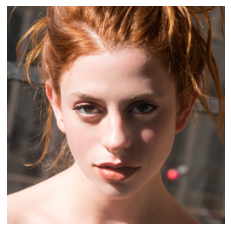

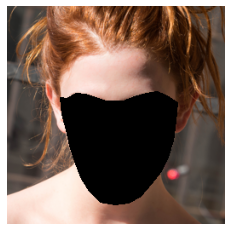

In [16]:
%matplotlib inline
original_path = '/content/drive/MyDrive/stylegan-encoder/00000/00041.png'
original_image = Image.open(original_path)
original_image = original_image.convert("RGB").resize((256,256))
original_image.save('tempimage/0000.png')
image_ori_path = '/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/tempimage/0000.png'
_,lm = run_alignment(image_ori_path)
mask = generate_mask(lm)
image_no_face = np.array(original_image)-np.array(original_image)*np.expand_dims(mask,axis=2)

plt.imshow(original_image)
plt.axis('off')
plt.show()
plt.imshow(image_no_face)
plt.axis('off')
plt.show()

## 3.2 generate image start from latent

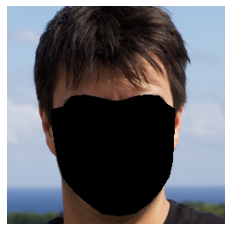

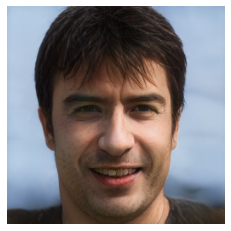

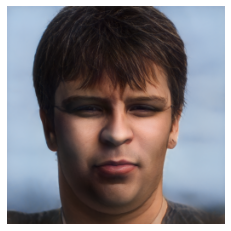

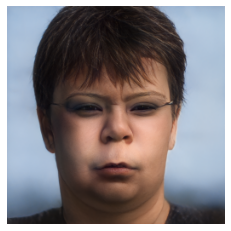

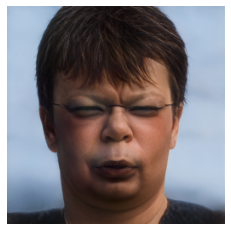

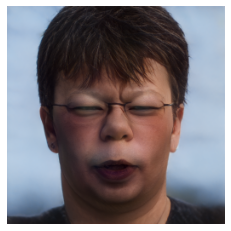

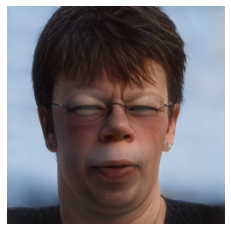

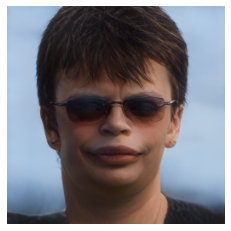

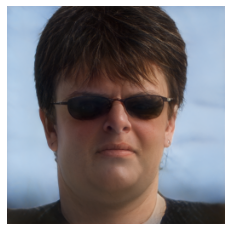

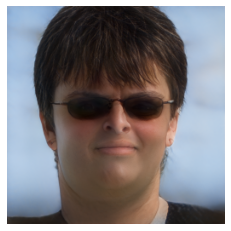

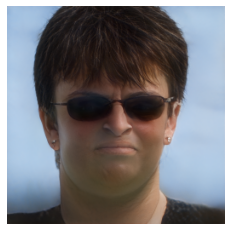

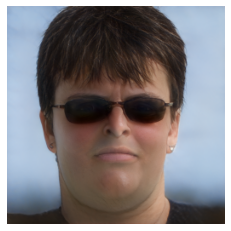

In [18]:
%matplotlib inline
#please change this date
test_date = '09_May_2021'
image_number=11133
# latent_I = latent_code[image_number]
latent_I = np.load('/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/tempimage/temp_save/11133/image_11133_0_20_May_2021.npy')

img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# original_path = '/content/drive/MyDrive/stylegan-encoder/00000/00012.png'
original_path = '11133.png'

original_image = Image.open(original_path)
original_image = original_image.convert("RGB").resize((256,256))
original_image.save('tempimage/0000.png')
image_ori_path = '/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/tempimage/0000.png'
_,lm = run_alignment(image_ori_path)
default_lm = lm.copy()

mask = generate_mask(lm)
image_no_face = np.array(original_image)-np.array(original_image)*np.expand_dims(mask,axis=2)
plt.imshow(image_no_face)
plt.axis('off')
plt.show()

image_path = '/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/tempimage/0001.png'

latent_temp_path = '/content/drive/MyDrive/GANsLatentCode/pixel2style2pixel/tempimage/temp_save/'+str(image_number)
if not os.path.exists(latent_temp_path):
    os.makedirs(latent_temp_path)

for i in range(0,101,1):
    # latent_I = 5*latent_I / np.max(abs(latent_I))
    # latent_I = np.clip(latent_I,-45,45)
    latent_rand = np.random.normal(0,0.2,[18,512])
    mask_zeros = np.zeros([18,512])
    mask_zeros[0:7] = 1
    latent_dp = latent_I+latent_rand*mask_zeros
    # latent_clip = np.clip(latent_dp,-45,45)
    input_latent = hy_latent(latent_dp)
    with torch.no_grad():
        result_image_temp, _, _ = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    # figsize = 4,4
    # figure, ax = plt.subplots(figsize=figsize)
    # plt.imshow(res_image_temp)
    # plt.title('01220.png')
    # plt.axis('off')
    res_image_temp.save('tempimage/0001.png')
    # res_image_temp.save("00018_untar.eps")
    # plt.show()    
    input_image_T, _ = run_alignment(image_path, default_lm)
    input_image_np = np.array(input_image_T)*np.expand_dims(mask,axis=2)+image_no_face
    # plt.imshow(input_image_np)
    # plt.axis('off')
    # plt.show()
    input_image = Image.fromarray(input_image_np)

    transformed_image = img_transforms(input_image)
    with torch.no_grad():
        _, latent,_ = run_on_batch(transformed_image.unsqueeze(0), net)
          
    latent_np = latent.cpu().detach().numpy()
    latent_I = latent_np[0]


    if i%10==0:
      # file_temp_path = latent_temp_path+'/'+'image_'+str(image_number)+'_'+str(i)+'_'+test_date+'.npy'
      # np.save(file_temp_path, latent_I)
      figsize = 4,4
      figure, ax = plt.subplots(figsize=figsize)
      plt.imshow(res_image_temp)
      # plt.title('01220.png')
      plt.axis('off')
      # temp_image_name = str(image_number)+'_idlayer_T'+str(i)+'.png'
      # res_image_temp.save(temp_image_name)
      plt.show()


# Section 4 Evaluations

In [ ]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
latent_avg = np.mean(latent_code,axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  Our method
# ------------------------------------------------------
    lamda = 0

    latent_gt = latent_code[i]
    latent_untar = lamda*latent_gt+(1-lamda)*latent_avg
    input_latent = hy_latent(latent_untar)

    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    # res_image_temp = Image.fromarray(np.array(output_image_temp))
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = np.array(output_image_temp.resize((256, 256)))
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

l2_name = "l2_untar_"+str(int(lamda*100))+".npy"
aldp_name = "aldp_untar_"+str(int(lamda*100))+".npy"
ssim_name = "ssim_untar_"+str(int(lamda*100))+".npy"
arcface_name = "arcface_untar_"+str(int(lamda*100))+".npy"
fid_name = "fid_untar_"+str(int(lamda*100))+".npy"
facenet_name = "facenet_untar_"+str(int(lamda*100))+".npy"

np.save(l2_name,l2_list)
np.save(aldp_name,aldp_list)
np.save(ssim_name,ssim_list)
np.save(arcface_name,arcface_list)
np.save(fid_name,fid_list)
np.save(facenet_name,facenet_list)
        
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)